In [1]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
from loguru import logger

In [3]:
import sys
sys.path.append('/home/mowp/workspace/mowp_scripts/tools')


import os
os.environ['R_HOME'] = '/home/mowp/mambaforge/envs/sc/lib/R'

%load_ext autoreload
%autoreload 1
%aimport sctk

In [4]:
sc.set_figure_params(figsize=(3, 3))

In [5]:
adata = sctk.sample_data.NeurIPS_filtered()
adata.var_names_make_unique()
adata

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

## Cell QC

In [6]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# # ribosomal genes
# adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# # hemoglobin genes.
# adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [7]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

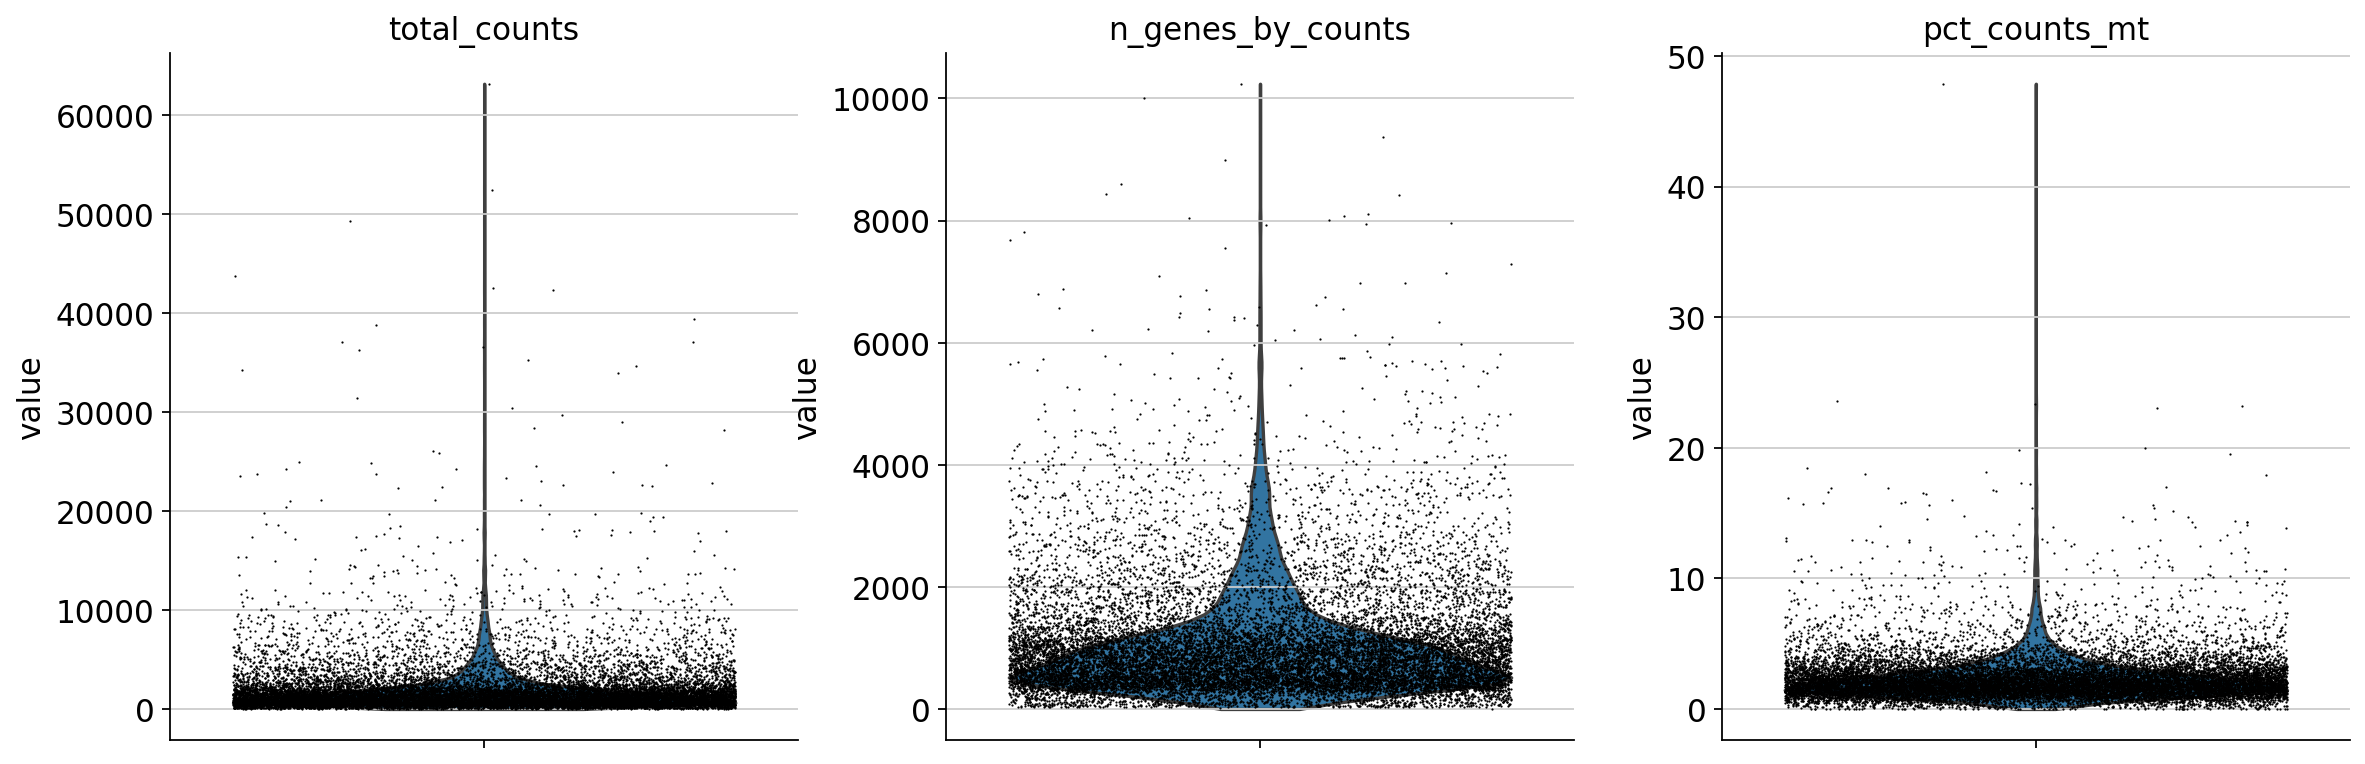

In [8]:
sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
# sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, log=True)

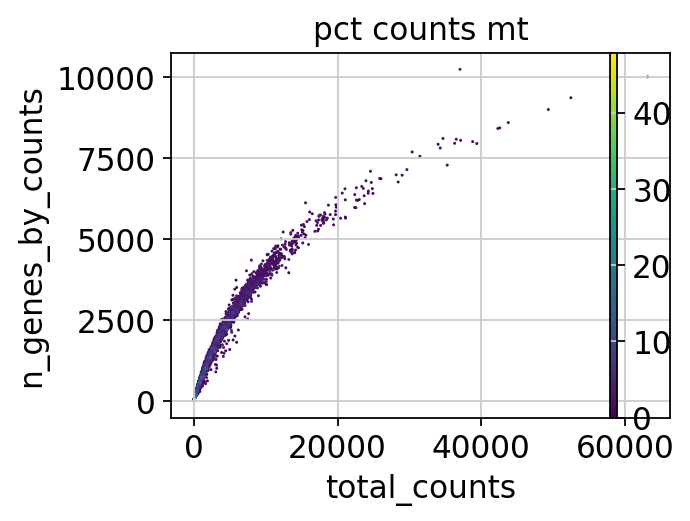

In [9]:
fig, ax = plt.subplots(figsize=(4, 3))
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", ax=ax)

In [10]:
adata.obs["outlier"] = (
    sctk.pp.is_outlier(adata, "log1p_total_counts", 5)
    | sctk.pp.is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | sctk.pp.is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    16065
True       869
Name: outlier, dtype: int64

In [11]:
adata.obs["mt_outlier"] = sctk.pp.is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

False    15240
True      1694
Name: mt_outlier, dtype: int64

In [12]:
logger.info(f"Before filtering : {adata.n_obs} cells")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

logger.info(f"After filtering: {adata.n_obs} cells")

2023-11-03 14:27:35.802 | INFO     | __main__:<module>:1 - Before filtering : 16934 cells
2023-11-03 14:27:35.923 | INFO     | __main__:<module>:4 - After filtering: 14814 cells


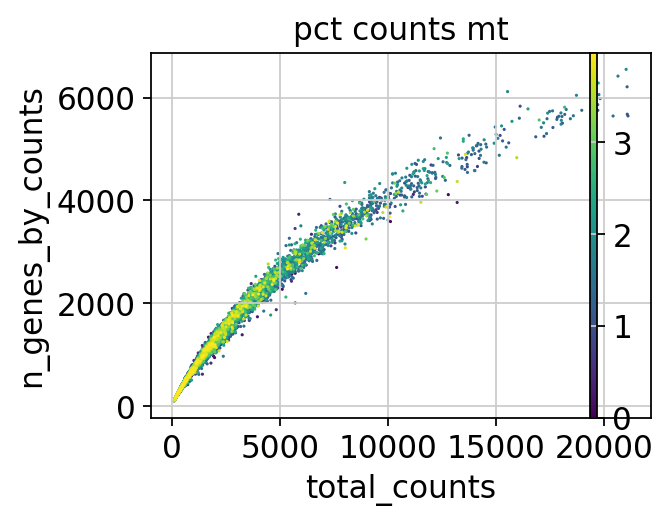

In [13]:
fig, ax = plt.subplots(figsize=(4, 3))
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", ax=ax)

## Remove ambient RNA

In [14]:
# SoupX additionally required the raw gene by cells matrix

adata_raw =  sctk.sample_data.NeurIPS_raw()
adata_raw.var_names_make_unique()
adata_raw

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 692666 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [15]:
adata.layers['raw'] = adata.X
adata_raw.layers['raw'] = adata_raw.X

In [16]:
sctk.pp.remove_ambient(adata, adata_raw)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: 408 genes passed tf-idf cut-off and 203 soup quantile filter.  Taking the top 100.

R[write to console]: Using 451 independent estimates of rho.

R[write to console]: Estimated global rho of 0.06

R[write to console]: Expanding counts from 15 clusters to 14814 cells.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
R[write to console]: 
 
R[write to console]:  'giveCsparse' is deprecated; setting repr="T" for you



<Axes: >

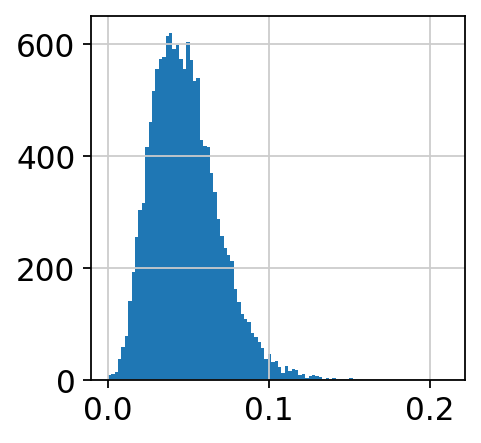

In [17]:
adata.obs['soupX_ambient_frac'].hist(bins=100)

In [18]:
logger.info(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
logger.info(f"Number of genes after cell filter: {adata.n_vars}")

2023-11-03 14:29:24.870 | INFO     | __main__:<module>:1 - Total number of genes: 36601
2023-11-03 14:29:25.474 | INFO     | __main__:<module>:5 - Number of genes after cell filter: 20199


In [19]:
del adata_raw

## Doublet detection

In [20]:
adata = sctk.pp.scDblFinder(adata, n_jobs=8)

R[write to console]: Creating ~11852 artificial doublets...

R[write to console]: Dimensional reduction

R[write to console]: Evaluating kNN...

R[write to console]: Training model...

R[write to console]: iter=0, 3485 cells excluded from training.

R[write to console]: iter=1, 3725 cells excluded from training.

R[write to console]: iter=2, 3691 cells excluded from training.

R[write to console]: Threshold found:0.549

R[write to console]: 2939 (19.8%) doublets called

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In .checkSCE(sce) :
R[write to console]: 
 
R[write to console]:  Some cells in `sce` have an extremely low read counts; note that these could trigger errors and might best be filtered out

2023-11-03 14:30:04.926 | INFO     | sctk.preprocessing.scDblFinder:scDblFinder:89 - Before dropping: 14814
2023-11-03 14:30:05.202 | INFO     | sctk.preprocessing.scDblFinder:scDblFinder:91 - After dropping: 11875


In [21]:
adata_qc = adata.copy()

In [22]:
adata

AnnData object with n_obs × n_vars = 11875 × 20199
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'soupX_ambient_frac', 'scDblFinder_score', 'scDblFinder_class'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'raw', 'soupX_counts'

## Select HVG

In [49]:
adata = adata_qc.copy()

In [23]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
)

In [24]:
pp_set = set(adata.var[adata.var['highly_variable']].index)

### alternative: select HVG by `sc.experimental.pp.highly_variable_genes`

In [38]:
adata = adata_qc.copy()

In [39]:
sc.experimental.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
)

In [42]:
exp_set = set(adata.var[adata.var['highly_variable']].index)

In [48]:
len(pp_set & exp_set)

903

## Normalization

In [25]:
scales_counts = sc.pp.normalize_total(adata, target_sum=1e4, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [26]:
adata

AnnData object with n_obs × n_vars = 11875 × 20199
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'soupX_ambient_frac', 'scDblFinder_score', 'scDblFinder_class'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    layers: 'raw', 'soupX_counts', 'log1p_norm'

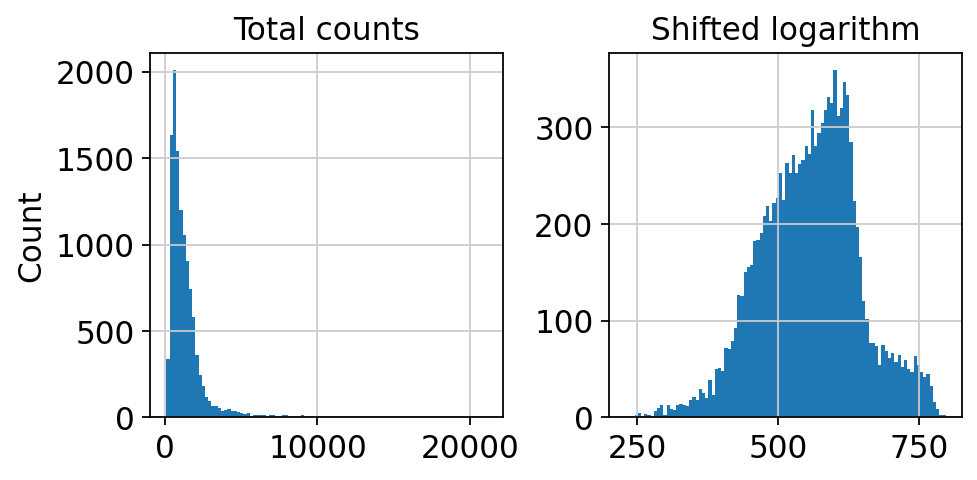

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 3))
ax[0].hist(adata.obs["total_counts"], bins=100)
ax[0].set_title("Total counts")
ax[0].set_ylabel("Count")

ax[1].hist(adata.layers["log1p_norm"].sum(1), bins=100)
ax[1].set_title("Shifted logarithm")

plt.subplots_adjust(wspace=0.3)

## PCA

In [28]:
adata.X = adata.layers["log1p_norm"]

In [29]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)

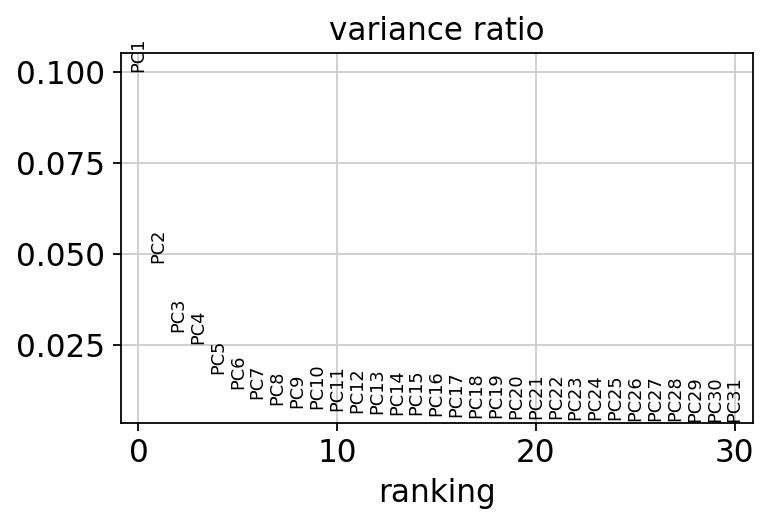

In [30]:
with plt.rc_context({"figure.figsize": (5, 3)}):
    sc.pl.pca_variance_ratio(adata)

## UMAP

In [31]:
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.umap(adata)

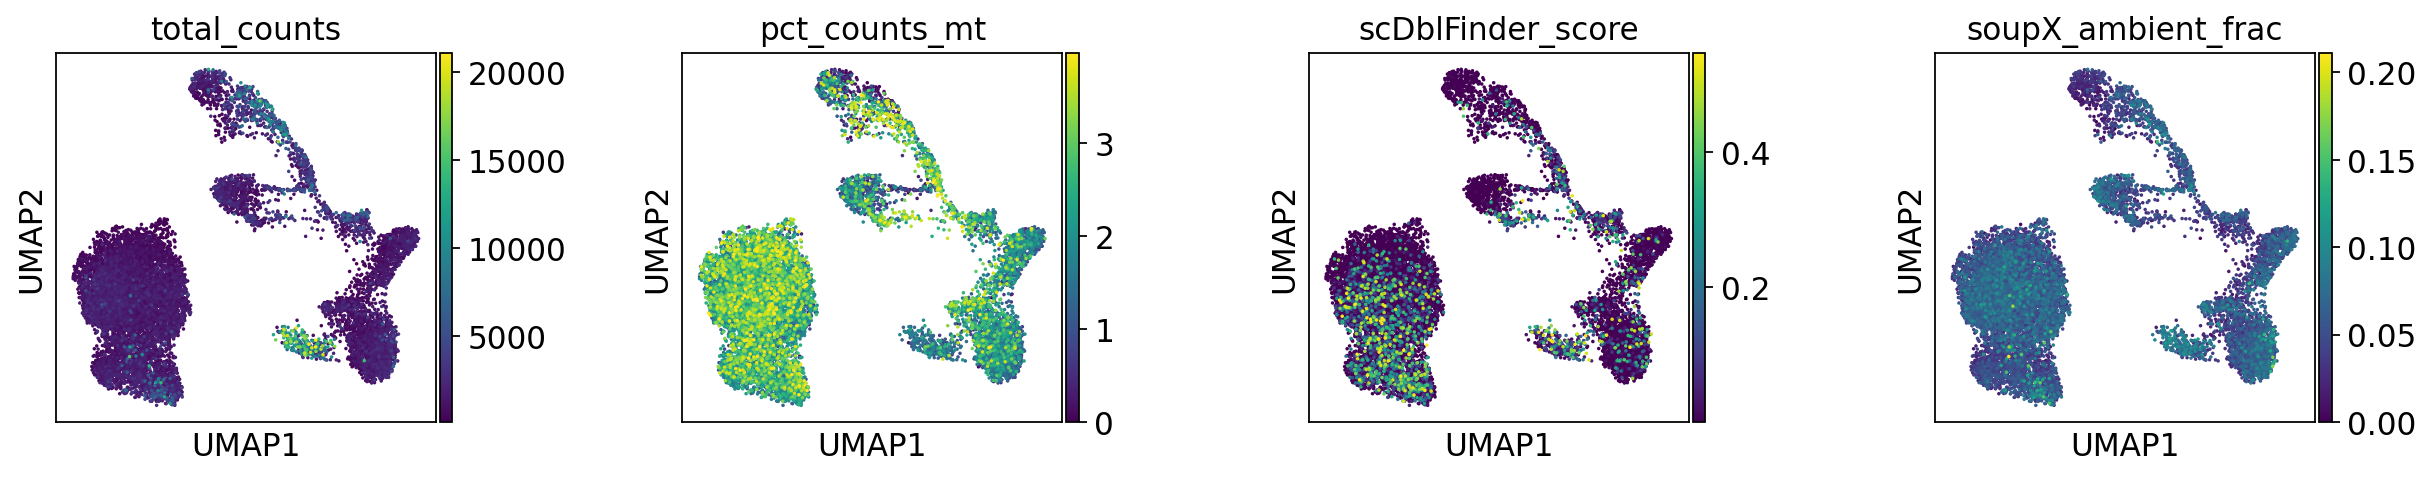

In [34]:
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "scDblFinder_score", "soupX_ambient_frac"],
    wspace=.5
)

In [35]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


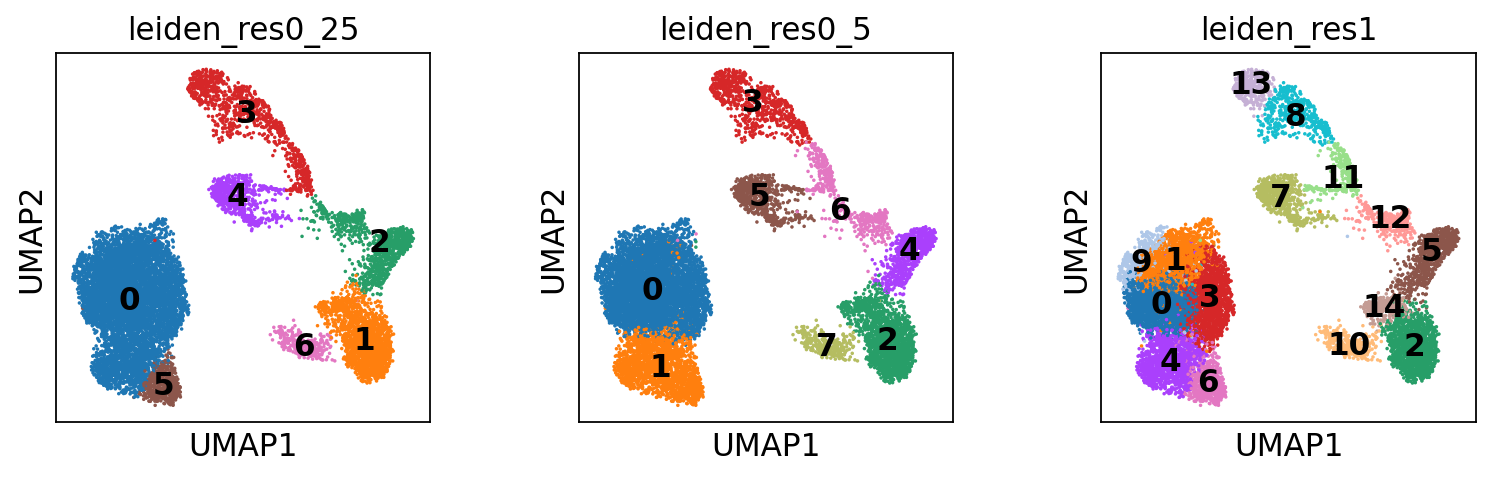

In [36]:
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)